In [1]:
from segment_this_thing import Foveator, SegmentThisThingPredictor
from segment_this_thing import build_segment_this_thing_b
from gym_av_aloha.datasets.av_aloha_dataset import AVAlohaDataset
from torch.utils.data import DataLoader
from torch import nn, Tensor
import torch
from pathlib import Path
import os
import gaze_av_aloha
from segment_this_thing import build_segment_this_thing_b
from segment_this_thing import Foveator, SegmentThisThingPredictor
from torchvision.ops import roi_align
import requests
from tqdm import tqdm
from typing import Optional
import torch
from itertools import islice
from typing import List
import torch
import matplotlib.pyplot as plt

In [2]:
CACHE_DIR = Path(os.path.dirname(os.path.dirname(gaze_av_aloha.__file__))) / "cache"

def download_file(url: str, filename: str):
    if not os.path.exists(filename):
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        print(f"Downloading {filename}...")
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            block_size = 1024  # 1 Kilobyte
            with open(filename, 'wb') as f, tqdm(
                total=total_size, unit='iB', unit_scale=True
            ) as bar:
                for data in response.iter_content(block_size):
                    f.write(data)
                    bar.update(len(data))
            print(f"Downloaded {filename}")
        else:
            print(f"Failed to download {filename}. Status code: {response.status_code}")

In [3]:
# create dataset
fps = 8.33333333333333
observation_indices = [0]
observation_timestamps = [i/fps for i in observation_indices]
delta_timestamps = {
    "observation.images.zed_cam_left": observation_timestamps,
    "left_eye": observation_timestamps,
}
dataset = AVAlohaDataset(
    repo_id="iantc104/av_aloha_sim_hook_package", 
    delta_timestamps=delta_timestamps,
)
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
)

In [4]:
batch = next(iter(dataloader))

In [5]:
def get_imagenet_mean(device: Optional[torch.device] = None) -> torch.Tensor:
    return torch.tensor([0.485, 0.456, 0.406], device=device)

def get_imagenet_std(device: Optional[torch.device] = None) -> torch.Tensor:
    return torch.tensor([0.229, 0.224, 0.225], device=device)

def get_crop_bounds(center: torch.Tensor, crop_size: int) -> torch.Tensor:
    lower_corner = (center - crop_size / 2).int()
    upper_corner = lower_corner + crop_size
    return torch.stack([lower_corner, upper_corner])

def get_centered_crop(image: torch.Tensor, crop_bounds: torch.Tensor) -> torch.Tensor:
    if image.ndim != 3:
        raise ValueError(f"Image must be 3D, got {image.shape}")
    if image.shape[-1] != 3:
        raise ValueError(f"Image must have 3 channels, got {image.shape[-1]}")

    device = image.device
    if device != crop_bounds.device:
        raise RuntimeError("Expected image and crop_bounds to be on the same device.")

    lower_corner, upper_corner = crop_bounds
    lower_pad = (-lower_corner).clamp(min=0)
    upper_pad = (upper_corner - torch.tensor(image.shape[1::-1], device=device)).clamp(
        min=0
    )

    lower_corner = lower_corner + lower_pad
    upper_corner = upper_corner - upper_pad
    crop = image[
        lower_corner[1] : upper_corner[1], lower_corner[0] : upper_corner[0], :
    ]

    filler = (255.0 * get_imagenet_mean()).round().byte().view(1, 1, 3).to(device)

    if lower_pad[0] > 0:
        crop = torch.cat(
            [
                filler.view(1, 1, 3).expand(crop.shape[0], lower_pad[0], -1),
                crop,
            ],
            dim=1,
        )
    if upper_pad[0] > 0:
        crop = torch.cat(
            [
                crop,
                filler.view(1, 1, 3).expand(crop.shape[0], upper_pad[0], -1),
            ],
            dim=1,
        )
    if lower_pad[1] > 0:
        crop = torch.cat(
            [filler.view(1, 1, 3).expand(lower_pad[1], crop.shape[1], -1), crop]
        )
    if upper_pad[1] > 0:
        crop = torch.cat(
            [crop, filler.view(1, 1, 3).expand(upper_pad[1], crop.shape[1], -1)]
        )

    return crop

In [33]:
def is_monotonically_increasing(vals: List[int]) -> bool:
    return all(y > x for x, y in zip(vals[:-1], vals[1:]))

def compute_integral_image(image: torch.Tensor):
    padded = torch.nn.functional.pad(image, (1, 0, 1, 0), mode="constant", value=0)
    return padded.cumsum(dim=2, dtype=torch.int32).cumsum(dim=1, dtype=torch.int32)

def generate_grid_coords_2d(grid_size):
    x = torch.arange(grid_size)
    return torch.stack(torch.meshgrid(x, x, indexing="xy"), dim=-1)

class Foveator(torch.nn.Module):
    def __init__(
        self, token_size: int, strides: List[int], grid_sizes: List[int]
    ) -> None:
        super().__init__()

        num_levels = len(strides)
        if len(grid_sizes) != num_levels:
            raise ValueError(
                "[Foveator]: Constructor arguments 'strides' and 'grid_sizes' must have the same length."
            )

        if not is_monotonically_increasing(strides):
            raise ValueError(
                "[Foveator]: Constructor agrument 'strides' should have monotonically increasing values."
            )

        # Block sizes are in multiples of stride-1 tokens.
        self.block_sizes = [
            stride * grid_size for stride, grid_size in zip(strides, grid_sizes)
        ]
        if not is_monotonically_increasing(self.block_sizes):
            raise ValueError(
                "[Foveator]: Constructor arguments 'strides' and 'grid_sizes' do not lead to monotonically increasing block sizes."
            )

        token_corner_indices_by_level = []

        self.ring_thickness_tokens = [None]

        for level_index, (stride, grid_size, block_size) in enumerate(
            zip(strides, grid_sizes, self.block_sizes)
        ):
            grid_coords = generate_grid_coords_2d(grid_size)
            offset = (self.block_sizes[-1] - block_size) // 2
            if level_index == 0:
                token_corner_indices_by_level.append(
                    offset + stride * grid_coords.flatten(0, 1)
                )
                continue

            prior_block_size = self.block_sizes[level_index - 1]
            redundant_grid_size = prior_block_size // stride
            if stride * redundant_grid_size != prior_block_size:
                raise ValueError(
                    "[Foveator]: Constructor arguments 'strides' and 'grid_sizes' do not lead to nestable block sizes."
                )
            ring_thickness_tokens = (grid_size - redundant_grid_size) // 2
            if ring_thickness_tokens * 2 + redundant_grid_size != grid_size:
                raise ValueError(
                    "[Foveator]: Constructor arguments 'strides' and 'grid_sizes' do not lead to evenly nestable block sizes."
                )
            # upper rows, include all columns
            level_corner_indices = [grid_coords[:ring_thickness_tokens].flatten(0, 1)]
            # central rows, exclude already-covered central columns
            for row in grid_coords[ring_thickness_tokens:-ring_thickness_tokens]:
                level_corner_indices.append(row[:ring_thickness_tokens])
                level_corner_indices.append(row[-ring_thickness_tokens:])
            # lower rows, include all columns
            level_corner_indices.append(
                grid_coords[-ring_thickness_tokens:].flatten(0, 1)
            )

            token_corner_indices_by_level.append(
                offset + stride * torch.cat(level_corner_indices)
            )

            self.ring_thickness_tokens.append(ring_thickness_tokens)

        self.token_size = token_size
        self.strides_by_level = strides
        self.grid_sizes_by_level = grid_sizes
        self.num_tokens_by_level = [
            len(corners) for corners in token_corner_indices_by_level
        ]
        self.register_buffer(
            "token_corner_indices",
            token_size * torch.cat(token_corner_indices_by_level),
            persistent=False,
        )
        self.register_buffer(
            "token_strides",
            torch.cat(
                [
                    torch.full((len(corners),), stride)
                    for corners, stride in zip(token_corner_indices_by_level, strides)
                ]
            ),
        )

    def get_pattern_bounds_size(self) -> int:
        return self.block_sizes[-1] * self.token_size

    def get_num_tokens(self) -> int:
        return len(self.token_strides)

    def extract_foveated_image(self, images: torch.Tensor) -> torch.Tensor:
        """
        # This function extracts a set of tokens representing a foveated version of the input image.
        # Input: images (Tensor of shape [C, H, W]).
        # Output: foveated tokens (Tensor of shape [N, C, H, W])
        """
        if not images.ndim == 3:
            raise ValueError(
                "[Foveator.extract_foveated_image]: Expected 3D input Tensor."
            )

        expected_input_size = self.token_size * self.block_sizes[-1]
        if (
            images.shape[-2] != expected_input_size
            or images.shape[-1] != expected_input_size
        ):
            raise ValueError(
                f"[Foveator.extract_foveated_image]: Expected square image of size {expected_input_size}"
            )
        if images.shape[-3] != 3:
            raise ValueError(
                f"[Foveator.extract_foveated_image]: Expected 3-channel image."
            )

        if images.dtype != torch.uint8:
            raise ValueError("[Foveator.extract_foveated_image]: Expected byte images.")

        device = images.device

        integral_image = compute_integral_image(images)

        # self.token_corner_indices is (N, U)
        # self.token_strides is (N)
        # generate_grid_coords_2d return (H, W, U)
        # All get mapped to (N, H, W, U)
        lower_pixel_coords = self.token_corner_indices.view(
            -1, 1, 1, 2
        ) + self.token_strides.view(-1, 1, 1, 1) * generate_grid_coords_2d(
            self.token_size
        ).unsqueeze(0).to(device)
        upper_pixel_coords = lower_pixel_coords + self.token_strides.view(-1, 1, 1, 1)

        return (
            torch.stack(
                [
                    integral_image_channel[
                        upper_pixel_coords[..., 1], upper_pixel_coords[..., 0]
                    ]
                    - integral_image_channel[
                        upper_pixel_coords[..., 1], lower_pixel_coords[..., 0]
                    ]
                    - integral_image_channel[
                        lower_pixel_coords[..., 1], upper_pixel_coords[..., 0]
                    ]
                    + integral_image_channel[
                        lower_pixel_coords[..., 1], lower_pixel_coords[..., 0]
                    ]
                    for integral_image_channel in integral_image
                ],
                1,
            )
            .floor_divide(self.token_strides.square().view(-1, 1, 1, 1).int())
            .byte()
        )

    def get_in_bounds_tokens(
        self,
        image_size: torch.Tensor,
        crop_bounds: torch.Tensor,
        in_bounds_threshold: float = 0.0,
    ) -> torch.Tensor:
        """
        # This function returns a binary mask indicating which tokens are sufficiently in bounds to be considered valid.
        # Input:
        # - image_size (Tensor of shape [2]): The size of the input image (width, height).
        # - crop_bounds (Tensor of shape [2, 2]): The bounds of the crop region ([[x1, y1], [x2, y2]]).
        # - in_bounds_threshold (float): The threshold for considering a token to be in bounds (tokens may be partially in bounds)
        # Output: valid_token_mask (Tensor of shape [N]): A binary mask indicating which tokens are valid.
        """
        foveation_offset = crop_bounds[0]
        token_corner_coordinates = foveation_offset + self.token_corner_indices

        bounded_lower_corners = token_corner_coordinates.clamp(min=0)
        bounded_upper_corners = torch.minimum(
            token_corner_coordinates + self.token_size * self.token_strides.view(-1, 1),
            image_size,
        )

        area_per_pixel = self.token_strides.square()

        in_bounds_area = (
            (bounded_upper_corners - bounded_lower_corners)
            .clamp(min=0)
            .prod(dim=-1)
            .float()
        )
        valid_token_mask = (
            in_bounds_area / area_per_pixel.float()
        ) > in_bounds_threshold

        return valid_token_mask

    def generate_foveated_visualization(self, tokens: torch.Tensor) -> torch.Tensor:
        """
        # This function reconstructs an image given a set of foveated tokens.
        # Input: foveated tokens (Tensor of shape [N, C, H, W]).
        # Output: image (Tensor of shape [C, H, W])
        """
        if not tokens.ndim == 4:
            raise ValueError(
                "[Foveator.generate_foveated_visualization]: Expected 4D input Tensor (N, C, H, W)."
            )
        if tokens.shape[0] != len(self.token_strides):
            raise ValueError(
                f"[Foveator.generate_foveated_visualization]: Expected {len(self.token_strides)} tokens"
            )
        if tokens.shape[-2] != self.token_size or tokens.shape[-1] != self.token_size:
            raise ValueError(
                f"[Foveator.generate_foveated_visualization]: Expected square tokens of size {self.token_size}"
            )

        C = tokens.shape[1]
        reconstruction_size = self.block_sizes[-1] * self.token_size

        reconstructed_image = torch.empty((C, reconstruction_size, reconstruction_size))

        tokens_by_level = torch.split(tokens, self.num_tokens_by_level)

        # insert the innermost block

        # unflatten | N, C, H, W     ->  I, J, C, H, W
        # permute   | I, J, C, H, W  ->  C, I, H, J, W
        # flatten   | C, I, H, J, W  ->  C, H, W
        inner_block = (
            tokens_by_level[0]
            .unflatten(0, (self.grid_sizes_by_level[0], self.grid_sizes_by_level[0]))
            .permute(2, 0, 3, 1, 4)
            .flatten(3, 4)
            .flatten(1, 2)
        )

        offset = self.token_size * (self.block_sizes[-1] - self.block_sizes[0]) // 2

        reconstructed_image[:, offset:-offset, offset:-offset] = inner_block

        # build up the reconstruction ring by ring
        for tokens, stride, grid_size, block_size, ring_thickness in islice(
            zip(
                tokens_by_level,
                self.strides_by_level,
                self.grid_sizes_by_level,
                self.block_sizes,
                self.ring_thickness_tokens,
            ),
            1,
            None,
        ):
            upsampled_tokens = tokens.repeat_interleave(stride, -1).repeat_interleave(
                stride, -2
            )
            row_height = upsampled_tokens.shape[-2]
            offset = self.token_size * (self.block_sizes[-1] - block_size) // 2
            i = 0
            for row in range(grid_size):
                if row < ring_thickness or row >= (grid_size - ring_thickness):
                    # these rows span the block width
                    reconstructed_image[
                        :,
                        offset + row * row_height : offset + (row + 1) * row_height,
                        offset : offset + self.token_size * block_size,
                    ] = (
                        upsampled_tokens[i : i + grid_size]
                        .permute(1, 2, 0, 3)
                        .flatten(2)
                    )
                    i += grid_size
                else:
                    # these rows are split in to by the higher-resolution center region
                    reconstructed_image[
                        :,
                        offset + row * row_height : offset + (row + 1) * row_height,
                        offset : offset + self.token_size * stride * ring_thickness,
                    ] = (
                        upsampled_tokens[i : i + ring_thickness]
                        .permute(1, 2, 0, 3)
                        .flatten(2)
                    )
                    i += ring_thickness
                    reconstructed_image[
                        :,
                        offset + row * row_height : offset + (row + 1) * row_height,
                        offset
                        + self.token_size
                        * stride
                        * (grid_size - ring_thickness) : offset
                        + self.token_size * block_size,
                    ] = (
                        upsampled_tokens[i : i + ring_thickness]
                        .permute(1, 2, 0, 3)
                        .flatten(2)
                    )
                    i += ring_thickness

        return reconstructed_image


In [34]:
download_file(
    "https://huggingface.co/facebook/segment_this_thing/resolve/main/stt-b-qbkbmb5qsb4q2.pth",
    CACHE_DIR / "stt-b.pth"
)
foveator = Foveator(
    token_size=16, strides=[1, 2, 4, 6, 8], grid_sizes=[4, 4, 6, 8, 10]
).cuda()
stt = build_segment_this_thing_b(
    num_tokens=foveator.get_num_tokens(),
    token_size=16
)
stt.load_state_dict(
    torch.load(CACHE_DIR / "stt-b.pth", map_location="cpu")
)
model = stt.cuda()



In [36]:
from torchvision.transforms import Resize
import einops
import time

images = batch["observation.images.zed_cam_left"].cuda()
foveation_centers = batch["left_eye"].cuda().clone()
device = images.device

batch_size = images.shape[0]
images = einops.rearrange(
    images, "b t c h w -> (b t) c h w"
)
images = Resize((960, 1280))(images) 
images = (images.permute(0, 2, 3, 1) * 255.0).byte()  # Convert to uint8

foveation_centers = einops.rearrange(
    foveation_centers, "b t c -> (b t) c"
)
foveation_centers[...,0] = ((foveation_centers[...,0] + 1) / 2 * 1280)
foveation_centers[...,1] = ((foveation_centers[...,1] + 1) / 2 * 960)


image = images[0]
foveation_center = foveation_centers[0]

crop_bounds = get_crop_bounds(
    foveation_center, foveator.get_pattern_bounds_size()
).to(device)

print(f"Crop bounds: {crop_bounds}, shape: {crop_bounds.shape}")

start_time = time.perf_counter()
crop = get_centered_crop(image, crop_bounds)
print(f"Crop time: {time.perf_counter() - start_time:.4f} seconds")

print(f"crop shape: {crop.shape}, dtype: {crop.dtype}, device: {crop.device}")
print("torch.tensor(image.shape[1::-1]", torch.tensor(image.shape[1::-1]))
valid_token_mask = foveator.get_in_bounds_tokens(
    torch.tensor(image.shape[1::-1], device=device), crop_bounds.to(device)
).unsqueeze(0)

print(f"valid_token_mask shape: {valid_token_mask.shape}, dtype: {valid_token_mask.dtype}, device: {valid_token_mask.device}")
print(f"valid_token_mask shape: {valid_token_mask.shape}, valid_token_mask: {valid_token_mask}")

foveation = foveator.extract_foveated_image(
    crop.permute(2, 0, 1).to(device)
).unsqueeze(0)

norm_foveation = (foveation - 255.0 * get_imagenet_mean(device).view(3, 1, 1)) / (255.0 * get_imagenet_std(device).view(3, 1, 1))

print(f"foveation shape: {foveation.shape}, dtype: {foveation.dtype}, device: {foveation.device}")
print(norm_foveation)

masks, ious = model(
    norm_foveation,
    valid_token_mask,
)


Crop bounds: tensor([[   4, -173],
        [1284, 1107]], device='cuda:0', dtype=torch.int32), shape: torch.Size([2, 2])
Crop time: 0.0016 seconds
crop shape: torch.Size([1280, 1280, 3]), dtype: torch.uint8, device: cuda:0
torch.tensor(image.shape[1::-1] tensor([1280,  960])
valid_token_mask shape: torch.Size([1, 172]), dtype: torch.bool, device: cuda:0
valid_token_mask shape: torch.Size([1, 172]), valid_token_mask: tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  Tru

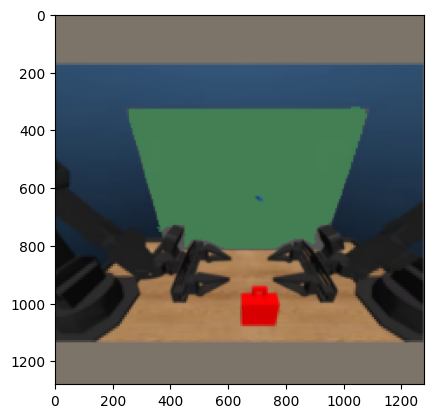

In [30]:

masks = masks[0]
ious = ious[0]
foveation = foveation[0]

k = ious.argmax().item()
ious = ious[k : k + 1]
masks = masks[k : k + 1]

num_masks = len(masks)
num_plots = 1 + num_masks


for k, (mask, iou) in enumerate(zip(masks, ious)):
    segmentation = foveator.generate_foveated_visualization(
        mask.unsqueeze(1)
    ).sigmoid()

    recon = foveator.generate_foveated_visualization(foveation)

    plt.imshow(
        torch.where(
            segmentation > 0.5,
            (
                0.5 * recon.float()
                + 0.5 * torch.tensor([0x32, 0xA8, 0x52]).view(3, 1, 1)
            ),
            recon,
        )
        .permute(1, 2, 0)
        .byte()
        .cpu()
        .numpy(),
    )
